# Functions

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

torch.manual_seed(1)

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff



In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
from torchvision import transforms, models
from sklearn.model_selection import KFold
# Define your image transformations for training and testing
from torchvision import transforms
# Custom dataset class
import os
import csv
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F
import json

# custom dataset on csv files
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['ImagePath']
        label = item['Label']

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to numerical representation
        if label == 'NFF':
            label = 0
        elif label == 'AFF':
            label = 1
        else:
            raise ValueError("Invalid label in JSON data.")

        return image, label

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Define data augmentation transforms for validation data
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load JSON data
with open('/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/combined_data3.json', 'r') as json_file:
    json_data = json.load(json_file)
    train_data = json_data['train']
    val_data = json_data['val']

train_dataset = CustomDataset(train_data, transform=train_transforms)
val_dataset = CustomDataset(val_data, transform=val_transforms)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)


# # print images
# show_image(train_dataset, 5)

# calculate numbers
print("train")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")

print("val")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in val_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in val_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")


training class weight [0.7018518518518518, 1.738532110091743]
train
-----------------------------------
train AFF: 109, ratio: 0.29
----- NFF: 270, ratio: 0.71
val
-----------------------------------
train AFF: 37, ratio: 0.22
----- NFF: 135, ratio: 0.78


In [3]:
# custom dataset on csv files
class CustomCsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.hospital_ids = []  # Store hospital IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                hospital_id = row['HospitalID']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)
                self.hospital_ids.append(int(hospital_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
import torch
import random
import numpy as np

# 设置随机数种子
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# 设置CUDA随机数种子（如果使用GPU）
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report




# ------------------------------------------------------------------------------------------------------
def train_custom_model(model, train_dataset, val_dataset, num_epochs, batch_size, optimizer=None):
    classweight = get_classweight(train_dataset) # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train ACC: {train_accuracy:.2f}%, "
              f"Validation ACC: {validation_accuracy:.2f}%")
    
    return model

# ------------------------------------------------------------------------------------------------------
def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = 100 * (correct_test_nff / total_nff) if total_nff != 0 else 0
    test_accuracy_aff = 100 * (correct_test_aff / total_aff) if total_aff != 0 else 0
    test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    # Handle the case where there is only one class
    if len(set(all_labels)) > 1:
        auc_score = roc_auc_score(all_labels, all_predictions)
    else:
        auc_score = 0  # Default value if only one class is present

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions, target_names=target_names, labels=[0, 1], zero_division=1)

    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Total Test Accuracy": test_accuracy_total,
        "Test Accuracy (NFF)": test_accuracy_nff,
        "Test Accuracy (AFF)": test_accuracy_aff,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    return metrics


In [6]:
results = []

# VGG 19

In [7]:
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

v19 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


Epoch 1/20, Train ACC: 53.03%, Validation ACC: 74.42%
Epoch 2/20, Train ACC: 58.84%, Validation ACC: 25.58%
Epoch 3/20, Train ACC: 54.88%, Validation ACC: 80.81%
Epoch 4/20, Train ACC: 68.07%, Validation ACC: 77.91%
Epoch 5/20, Train ACC: 75.46%, Validation ACC: 85.47%
Epoch 6/20, Train ACC: 78.63%, Validation ACC: 87.79%
Epoch 7/20, Train ACC: 81.79%, Validation ACC: 88.95%
Epoch 8/20, Train ACC: 83.11%, Validation ACC: 87.21%
Epoch 9/20, Train ACC: 88.39%, Validation ACC: 81.98%
Epoch 10/20, Train ACC: 85.75%, Validation ACC: 86.05%
Epoch 11/20, Train ACC: 84.70%, Validation ACC: 81.98%
Epoch 12/20, Train ACC: 89.97%, Validation ACC: 87.79%
Epoch 13/20, Train ACC: 86.81%, Validation ACC: 86.05%
Epoch 14/20, Train ACC: 93.40%, Validation ACC: 87.21%
Epoch 15/20, Train ACC: 89.45%, Validation ACC: 89.53%
Epoch 16/20, Train ACC: 92.61%, Validation ACC: 84.30%
Epoch 17/20, Train ACC: 91.82%, Validation ACC: 84.88%
Epoch 18/20, Train ACC: 90.77%, Validation ACC: 88.95%
Epoch 19/20, Train 


Performance for Hospital 1:

Test Loss: 0.13985246419906616
Total Test Accuracy: 95.65217391304348
Test Accuracy (NFF): 95.65217391304348
Test Accuracy (AFF): 0
Confusion Matrix:
 [[22  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.96      0.98        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.96        23
   macro avg       0.50      0.98      0.49        23
weighted avg       1.00      0.96      0.98        23


Performance for Hospital 2:

Test Loss: 0.30694761872291565
Total Test Accuracy: 66.66666666666667
Test Accuracy (NFF): 0
Test Accuracy (AFF): 66.66666666666666
Confusion Matrix:
 [[0 0]
 [1 2]]
Classification Report:
               precision    recall  f1-score   support

         NFF       0.00      1.00      0.00         0
         AFF       1.00      0.67      0.80         3

    accuracy                           0.67         3
   macro av

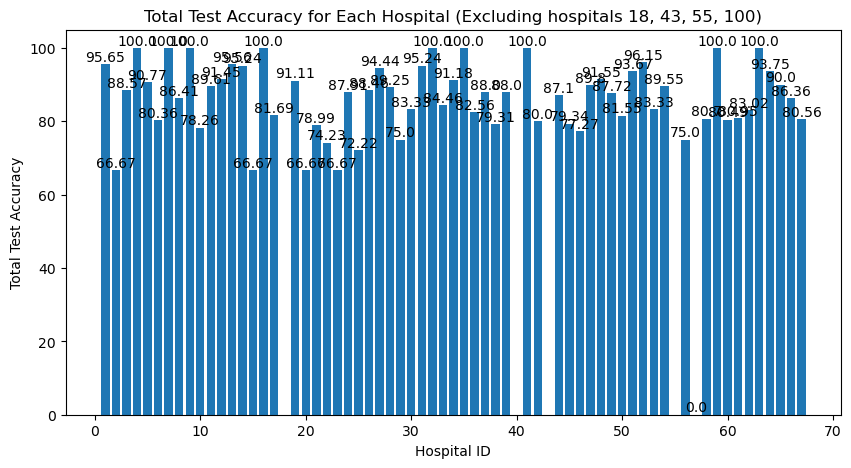

In [8]:
model = v19
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()
torch.cuda.empty_cache()
results.append(average_performance)


# ResNet50

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



Epoch 1/20, Train ACC: 62.53%, Validation ACC: 60.47%
Epoch 2/20, Train ACC: 67.81%, Validation ACC: 58.14%
Epoch 3/20, Train ACC: 69.92%, Validation ACC: 55.81%
Epoch 4/20, Train ACC: 75.99%, Validation ACC: 61.05%
Epoch 5/20, Train ACC: 75.46%, Validation ACC: 70.93%
Epoch 6/20, Train ACC: 75.99%, Validation ACC: 73.84%
Epoch 7/20, Train ACC: 81.27%, Validation ACC: 77.33%
Epoch 8/20, Train ACC: 84.17%, Validation ACC: 81.98%
Epoch 9/20, Train ACC: 87.86%, Validation ACC: 83.14%
Epoch 10/20, Train ACC: 90.50%, Validation ACC: 86.63%
Epoch 11/20, Train ACC: 91.82%, Validation ACC: 87.79%
Epoch 12/20, Train ACC: 94.46%, Validation ACC: 87.21%
Epoch 13/20, Train ACC: 91.82%, Validation ACC: 85.47%
Epoch 14/20, Train ACC: 93.93%, Validation ACC: 86.05%
Epoch 15/20, Train ACC: 95.78%, Validation ACC: 88.37%
Epoch 16/20, Train ACC: 94.99%, Validation ACC: 87.79%
Epoch 17/20, Train ACC: 93.93%, Validation ACC: 86.63%
Epoch 18/20, Train ACC: 96.31%, Validation ACC: 87.79%
Epoch 19/20, Train 


Performance for Hospital 1:

Test Loss: 0.17165926098823547
Total Test Accuracy: 95.65217391304348
Test Accuracy (NFF): 95.65217391304348
Test Accuracy (AFF): 0
Confusion Matrix:
 [[22  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.96      0.98        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.96        23
   macro avg       0.50      0.98      0.49        23
weighted avg       1.00      0.96      0.98        23


Performance for Hospital 2:

Test Loss: 0.2004300355911255
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00  

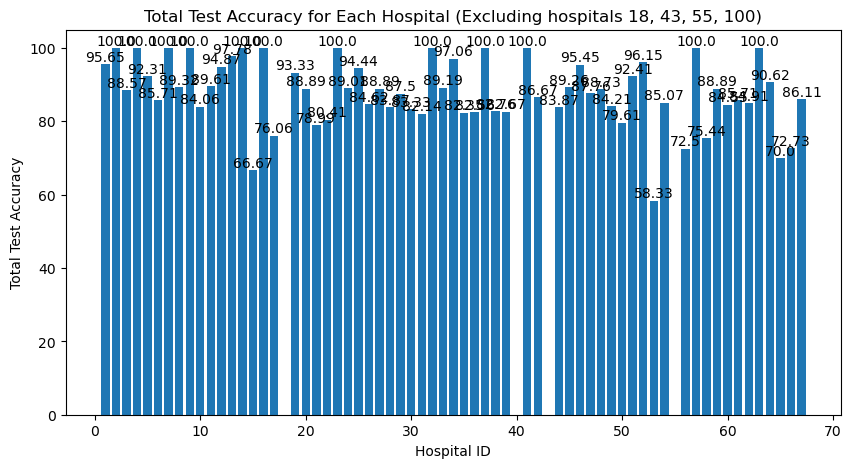

In [10]:
model = res50
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()
torch.cuda.empty_cache()
results.append(average_performance)




# ResNet101

In [11]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res101 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



Epoch 1/20, Train ACC: 49.08%, Validation ACC: 59.30%
Epoch 2/20, Train ACC: 63.85%, Validation ACC: 54.65%
Epoch 3/20, Train ACC: 62.80%, Validation ACC: 53.49%
Epoch 4/20, Train ACC: 70.18%, Validation ACC: 58.14%
Epoch 5/20, Train ACC: 75.99%, Validation ACC: 59.88%
Epoch 6/20, Train ACC: 78.36%, Validation ACC: 61.63%
Epoch 7/20, Train ACC: 83.38%, Validation ACC: 68.60%
Epoch 8/20, Train ACC: 83.38%, Validation ACC: 72.09%
Epoch 9/20, Train ACC: 89.71%, Validation ACC: 88.37%
Epoch 10/20, Train ACC: 89.97%, Validation ACC: 86.63%
Epoch 11/20, Train ACC: 93.14%, Validation ACC: 87.79%
Epoch 12/20, Train ACC: 91.03%, Validation ACC: 91.28%
Epoch 13/20, Train ACC: 93.93%, Validation ACC: 87.21%
Epoch 14/20, Train ACC: 93.93%, Validation ACC: 90.12%
Epoch 15/20, Train ACC: 94.99%, Validation ACC: 88.95%
Epoch 16/20, Train ACC: 97.89%, Validation ACC: 90.70%
Epoch 17/20, Train ACC: 96.31%, Validation ACC: 89.53%
Epoch 18/20, Train ACC: 98.42%, Validation ACC: 90.12%
Epoch 19/20, Train 


Performance for Hospital 1:

Test Loss: 0.0672973021864891
Total Test Accuracy: 95.65217391304348
Test Accuracy (NFF): 95.65217391304348
Test Accuracy (AFF): 0
Confusion Matrix:
 [[22  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.96      0.98        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.96        23
   macro avg       0.50      0.98      0.49        23
weighted avg       1.00      0.96      0.98        23


Performance for Hospital 2:

Test Loss: 0.07783495634794235
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00  

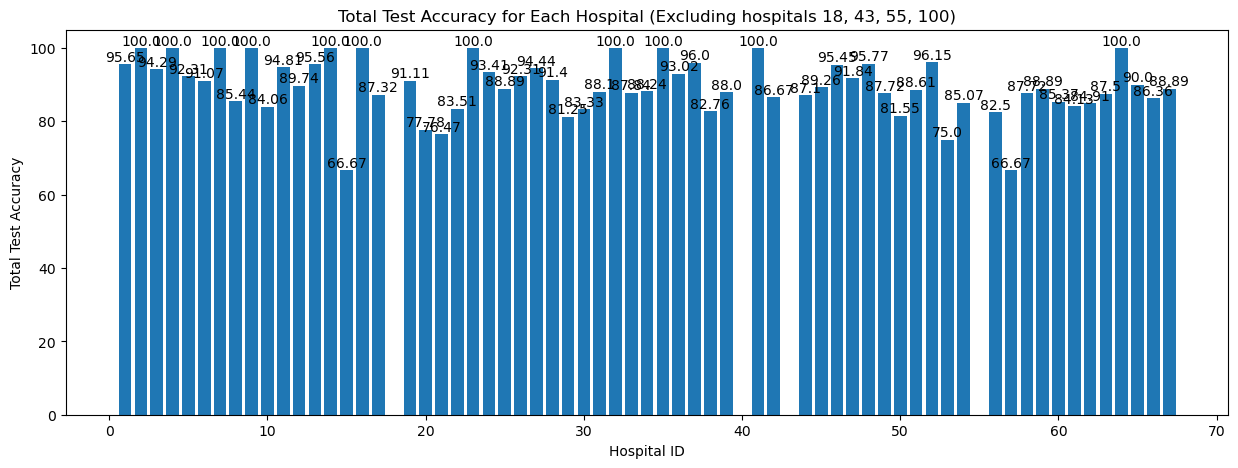

In [12]:
model = res101
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()
torch.cuda.empty_cache()
results.append(average_performance)




# ResNet152

In [13]:
from torchvision.models import resnet152, ResNet152_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res152 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



Epoch 1/20, Train ACC: 45.65%, Validation ACC: 50.00%
Epoch 2/20, Train ACC: 62.80%, Validation ACC: 72.67%
Epoch 3/20, Train ACC: 69.66%, Validation ACC: 74.42%
Epoch 4/20, Train ACC: 75.46%, Validation ACC: 76.16%
Epoch 5/20, Train ACC: 78.10%, Validation ACC: 82.56%
Epoch 6/20, Train ACC: 84.70%, Validation ACC: 82.56%
Epoch 7/20, Train ACC: 88.92%, Validation ACC: 83.14%
Epoch 8/20, Train ACC: 89.45%, Validation ACC: 86.05%
Epoch 9/20, Train ACC: 91.56%, Validation ACC: 85.47%
Epoch 10/20, Train ACC: 93.93%, Validation ACC: 88.37%
Epoch 11/20, Train ACC: 92.88%, Validation ACC: 87.21%
Epoch 12/20, Train ACC: 95.25%, Validation ACC: 86.63%
Epoch 13/20, Train ACC: 96.57%, Validation ACC: 85.47%
Epoch 14/20, Train ACC: 96.57%, Validation ACC: 90.12%
Epoch 15/20, Train ACC: 98.15%, Validation ACC: 89.53%
Epoch 16/20, Train ACC: 96.31%, Validation ACC: 85.47%
Epoch 17/20, Train ACC: 96.04%, Validation ACC: 82.56%
Epoch 18/20, Train ACC: 97.10%, Validation ACC: 87.79%
Epoch 19/20, Train 


Performance for Hospital 1:

Test Loss: 0.5050744414329529
Total Test Accuracy: 86.95652173913044
Test Accuracy (NFF): 86.95652173913044
Test Accuracy (AFF): 0
Confusion Matrix:
 [[20  3]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.87      0.93        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.87        23
   macro avg       0.50      0.93      0.47        23
weighted avg       1.00      0.87      0.93        23


Performance for Hospital 2:

Test Loss: 0.003274282207712531
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00 

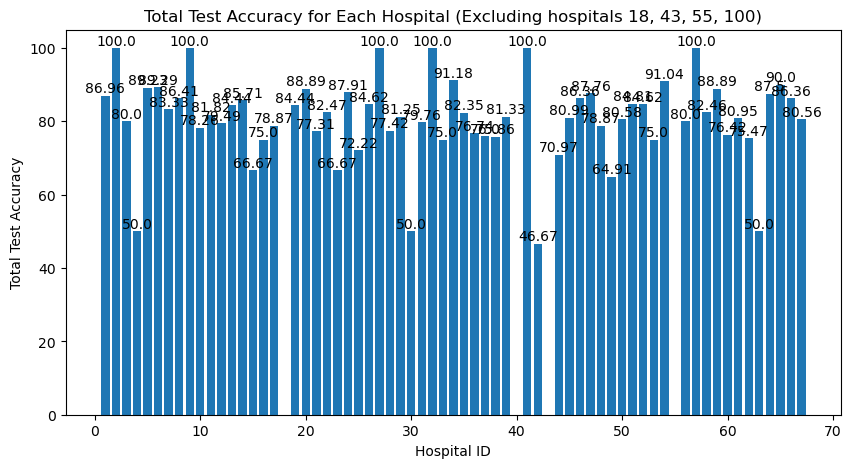

In [14]:
model = res152
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()
torch.cuda.empty_cache()
results.append(average_performance)


# DenseNet 161

In [15]:
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


Epoch 1/20, Train ACC: 65.96%, Validation ACC: 54.65%
Epoch 2/20, Train ACC: 64.64%, Validation ACC: 49.42%
Epoch 3/20, Train ACC: 70.98%, Validation ACC: 55.81%
Epoch 4/20, Train ACC: 79.68%, Validation ACC: 69.19%
Epoch 5/20, Train ACC: 87.34%, Validation ACC: 70.93%
Epoch 6/20, Train ACC: 89.97%, Validation ACC: 69.19%
Epoch 7/20, Train ACC: 92.35%, Validation ACC: 75.58%
Epoch 8/20, Train ACC: 94.20%, Validation ACC: 83.72%
Epoch 9/20, Train ACC: 95.25%, Validation ACC: 76.74%
Epoch 10/20, Train ACC: 97.63%, Validation ACC: 76.16%
Epoch 11/20, Train ACC: 95.78%, Validation ACC: 84.30%
Epoch 12/20, Train ACC: 97.89%, Validation ACC: 91.86%
Epoch 13/20, Train ACC: 98.68%, Validation ACC: 91.28%
Epoch 14/20, Train ACC: 98.68%, Validation ACC: 89.53%
Epoch 15/20, Train ACC: 98.42%, Validation ACC: 85.47%
Epoch 16/20, Train ACC: 96.83%, Validation ACC: 88.95%
Epoch 17/20, Train ACC: 98.94%, Validation ACC: 87.21%
Epoch 18/20, Train ACC: 98.15%, Validation ACC: 80.23%
Epoch 19/20, Train 


Performance for Hospital 1:

Test Loss: 0.32736992835998535
Total Test Accuracy: 86.95652173913044
Test Accuracy (NFF): 86.95652173913044
Test Accuracy (AFF): 0
Confusion Matrix:
 [[20  3]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.87      0.93        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.87        23
   macro avg       0.50      0.93      0.47        23
weighted avg       1.00      0.87      0.93        23


Performance for Hospital 2:

Test Loss: 0.0034374806564301252
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.0

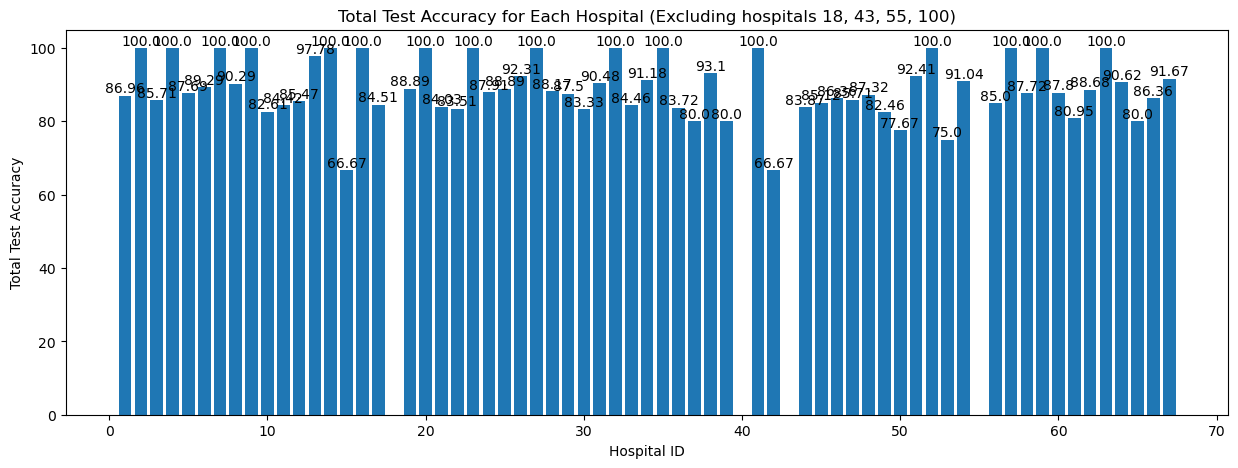

In [16]:
model = dense161
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()
torch.cuda.empty_cache()
results.append(average_performance)


In [17]:
results

[85.52376811471399,
 88.4475029191375,
 89.93011548353587,
 81.52843310839643,
 89.48803067339838]

# Efficient B2

In [18]:
# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# # Define the EfficientNetV2-M model
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

# # Access input features of the classifier
# num_features = model.classifier[1].in_features

# # Modify the classifier part of the model
# model.classifier[1] = nn.Linear(in_features=num_features, out_features=2)

# # Freeze certain layers
# total_layers = len(list(model.children()))
# freeze_layers = int(total_layers * 0.5)
# for index, child in enumerate(model.children()):
#     if index < freeze_layers:
#         for param in child.parameters():
#             param.requires_grad = False

# # Hyperparameters
# num_epochs = 20
# batch_size = 8
# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Move model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Train the model
# effi_b2 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)
